This tutorial requires the most recent version of Triton

In [2]:
!pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly


Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 MB 2.5 MB/s eta 0:00:00


In [3]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

def naive_softmax(x):
  """ compute row-wise softmax of x using native pytorch """

  # read MN elements; write M elements
  x_max = x.max(dim=1)[0]

  # read MN + M elements; write MN elements
  z = x - x_max[:, None]

  # read MN elements; write MN elements
  numerator = torch.exp(z)

  # read MN elements; write M elements
  denominator = numerator.sum(dim=1)

  # read MN + M elements; write MN elements
  ret = numerator / denominator[:, None] # (M, N) / (M, 1)

  # total read 5MN + 2M; total write 3MN + 2M
  return ret

Each program loads a set of rows of the input matrix X strided by # of programs

In [9]:
@triton.jit
def softmax_kernel(output_ptr,
                   input_ptr,
                   input_row_stride,
                   output_row_stride,
                   n_rows,
                   n_cols,
                   BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
  # start row of the program
  row_start = tl.program_id(0)
  row_step = tl.num_programs(0)
  for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
    # stride represents how much we need to increase the pointer to advance 1 row
    row_start_ptr = input_ptr + row_idx * input_row_stride

    # block size is the next power of two greater than n_cols,
    # so we can fit each row in a single block
    col_offsets = tl.arange(0, BLOCK_SIZE)
    input_ptrs = row_start_ptr + col_offsets

    # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
    mask = col_offsets < n_cols
    row = tl.load(input_ptrs, mask=mask, other=-float('inf'))

    # subtract maximum for numerical stability
    row_minus_max = row - tl.max(row, axis=0)

    # Note that exponentiation in Triton is fast but approximate
    numerator = tl.exp(row_minus_max)
    denominator = tl.sum(numerator, axis=0)

    softmax_output = numerator / denominator
    # write back output to DRAM
    output_row_start_ptr = output_ptr + row_idx * output_row_stride
    output_ptrs = output_row_start_ptr + col_offsets
    tl.store(output_ptrs, softmax_output, mask=mask)




In [10]:
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

def softmax(x):
  n_rows, n_cols = x.shape

  BLOCK_SIZE = triton.next_power_of_2(n_cols)

  # Another trick
  # ask compiler to use more threads per row by increasing # of warps
  # over which row is distributed
  num_warps = 8

  # # of software pipelining stages
  num_stages = 4 if SIZE_SMEM > 200000 else 2

  # allocate output
  y = torch.empty_like(x)

  # precompile kernel to get register usage and compute thread occupancy
  kernel, num_programs = kernels.get(BLOCK_SIZE, (None, 0))
  if kernel is None:
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols,
                                   BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages, grid=(1,))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy
    kernels[BLOCK_SIZE] = (kernel, num_programs)

  num_programs = min(num_programs, n_rows)

  # Create a number of persistent programs
  kernel[(num_programs, 1, 1)](
      y,
      x,
      x.stride(0),
      y.stride(0),
      n_rows,
      n_cols,
  )
  return y


In [11]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device='cuda')
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

In [16]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
  x = torch.randn(M, N, device='cuda', dtype=torch.float32)
  stream = torch.cuda.Stream()
  torch.cuda.set_stream(stream)
  if provider == 'torch':
    ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
  if provider == 'triton':
    ms = triton.testing.do_bench(lambda: softmax(x))
  gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
  return gbps(ms)

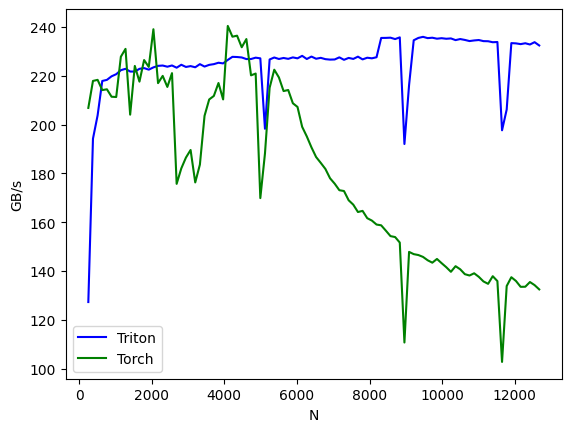

softmax-performance:
          N      Triton       Torch
0     256.0  127.293267  206.869867
1     384.0  194.257949  217.930649
2     512.0  203.836653  218.367950
3     640.0  217.913997  214.176941
4     768.0  218.361992  214.503199
5     896.0  219.825558  211.450739
6    1024.0  220.688658  211.336927
7    1152.0  222.336271  227.857458
8    1280.0  222.895163  231.072439
9    1408.0  221.782833  204.103793
10   1536.0  221.765255  224.084849
11   1664.0  222.890627  217.639813
12   1792.0  223.194722  226.486303
13   1920.0  222.550256  223.667915
14   2048.0  223.479947  239.116479
15   2176.0  224.109718  217.022095
16   2304.0  224.240007  219.997448
17   2432.0  223.758217  215.473911
18   2560.0  224.263497  221.128987
19   2688.0  223.354718  175.744986
20   2816.0  224.558795  182.070120
21   2944.0  223.661016  186.514527
22   3072.0  224.004792  189.621543
23   3200.0  223.526515  176.315732
24   3328.0  224.808736  183.622825
25   3456.0  223.816182  203.625616
26   35

In [17]:
benchmark.run(show_plots=True, print_data=True)